<a href="https://colab.research.google.com/github/KatrinaLiqy/SocialBotDetection/blob/main/Hyperparameter_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib
!pip install matplotlib --upgrade
matplotlib.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


'3.5.3'

In [17]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
import pandas as pd

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'models' #change this to whatever folder your code is in
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

#this directory contains the csv with all the models' metrics, and all tables generated in this notebook will go here
results_path = os.path.join(GOOGLE_DRIVE_PATH)

Mounted at /content/drive


In [ ]:
#this directory contains the csv with all the models' metrics, and all tables generated in this notebook will go here
#results_path = "./results/5_final_results/"

In [26]:
def csv_to_dataframe_to_ranked_results(results_file):
  #
  results = pd.read_csv(os.path.join(results_path, results_file))
  results["name"] = results.apply(lambda row: str(int(row["name"])).zfill(7), axis=1)
  ranks = results.drop("name", axis=1).rank(ascending=False).add_suffix("_rank")
  ranked_results = pd.concat([results, ranks], axis=1)
  metrics_to_eval = ["botwiki-verified_rank", "midterm-18_rank", "gilani-17_rank", "cresci-rtbust_rank", "5-fold_cross-validation_rank", "spearman_r_rank"]
  rank_product = ranked_results[metrics_to_eval].product(axis=1)
  #ranked_results = ranked_results.drop(labels=ranked_results.columns[7:],axis=1)
  ranked_results["rank"] = rank_product.rank(ascending=True)
  #ranked_results = ranked_results.round(decimals=2)
  return ranked_results




In [34]:
def ranked_comparison(ranked_results, ranked_results2):
  metrics_to_subtract = ["rank"]
  sub_abs = ranked_results[metrics_to_subtract].subtract(ranked_results2[metrics_to_subtract], axis=1).abs()
  average_change = sub_abs.sum().div(119).round()

  print(average_change)

In [44]:
def performance_eval(ranked_results):
  metrics_to_average = ["botwiki-verified", "midterm-18", "gilani-17", "cresci-rtbust", "5-fold_cross-validation", "spearman_r"]
  average = ranked_results[metrics_to_average].sum().div(119)
  sum_div_average = average.sum()/len(metrics_to_average)
  sum_div_average = sum_div_average.round(decimals=6)

  print(sum_div_average)

In [48]:
def performance_eval_top_n(ranked_results, n):
  metrics_to_average = ["botwiki-verified", "midterm-18", "gilani-17", "cresci-rtbust", "5-fold_cross-validation", "spearman_r"]
  top_results = ranked_results.sort_values("rank").head(n)
  average = top_results[metrics_to_average].sum().div(n)
  sum_div_average = average.sum()/len(metrics_to_average)
  sum_div_average = sum_div_average.round(decimals=6)

  print(sum_div_average)

In [46]:
#Most of the work is actually done, but in this cell, there will be a function which can take two sets of results with different hyperparameters.
def comparison(hyper, hyper2, n):
  ranked_res = csv_to_dataframe_to_ranked_results(hyper)
  ranked_res2 = csv_to_dataframe_to_ranked_results(hyper2)
  ranked_comparison(ranked_res, ranked_res2)
  print("performance of " + hyper)
  performance_eval(ranked_res)
  print("performance of " + hyper2)
  performance_eval(ranked_res2)
  print(hyper + " vs. " + hyper2)
  performance_eval_top_n(ranked_res,n)
  performance_eval_top_n(ranked_res2,n)  

In [59]:
n = 30
comparison("results_m_d_128.csv","results_m_feat_none.csv",n)
comparison("results_base.csv", "results_c_w_bal_sub.csv", n)
comparison("results_base.csv", "results_c_w_bal.csv", n)
comparison("results_c_w_bal.csv", "results_c_w_bal_sub.csv", n)
comparison("results_base.csv", "results_base.csv", n)

rank    7.0
dtype: float64
performance of results_m_d_128.csv
0.782813
performance of results_m_feat_none.csv
0.782867
results_m_d_128.csv vs. results_m_feat_none.csv
0.805458
0.805694
rank    15.0
dtype: float64
performance of results_base.csv
0.782098
performance of results_c_w_bal_sub.csv
0.782148
results_base.csv vs. results_c_w_bal_sub.csv
0.806363
0.815128
rank    13.0
dtype: float64
performance of results_base.csv
0.782098
performance of results_c_w_bal.csv
0.781912
results_base.csv vs. results_c_w_bal.csv
0.806363
0.814361
rank    8.0
dtype: float64
performance of results_c_w_bal.csv
0.781912
performance of results_c_w_bal_sub.csv
0.782148
results_c_w_bal.csv vs. results_c_w_bal_sub.csv
0.814361
0.815128
rank    0.0
dtype: float64
performance of results_base.csv
0.782098
performance of results_base.csv
0.782098
results_base.csv vs. results_base.csv
0.806363
0.806363


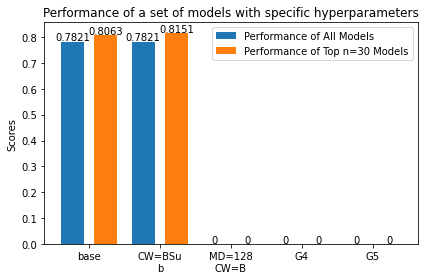

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from textwrap import wrap

labels = ['base',
          'CW=BSub',
          'MD=128\n CW=B\n', 'G4', 'G5']
labels = [ '\n'.join(wrap(l, 6)) for l in labels ]
overall_score = [0.7821, 0.7821, 0, 0, 0]
top_n_score = [0.8063, 0.8151, 0, 0, 0]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/1.5, overall_score, width/1.1, label='Performance of All Models')
rects2 = ax.bar(x + width/1.5, top_n_score, width/1.1, label='Performance of Top n=30 Models')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance of a set of models with specific hyperparameters')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=-1)
ax.bar_label(rects2, padding=-1)

fig.tight_layout()

plt.savefig("test.svg", format='svg')
plt.show()